<a href="https://colab.research.google.com/github/Yuan-Yu-Han/PTAS/blob/main/Time_Series_Prediction_Solution_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IE4424 Lab Time_Series_Prediction

## Acknowledgment

This lab experiment is inspired by Usman Malik's Stack Abuse article.

You can check out the original post at https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python



## 1. Training a time series predictor

A time series data is a sequential data indexed in time order.
Often we would like to predict the future behaviour of a time series.
For example, we may be interested in predicting the weather, share prices, sales, etc.

In this exercise, we will use the ``flights`` dataset from the seaborn library.
The dataset contains 3 columns: ``year``, ``month``, and ``passengers``.
Where the ``year`` and ``month`` columns refer to the particular year and month of the monthly flight record, respectively.
The ``passengers`` column records the total number of passengers that took the flights in that month.

We will do the following steps in order:

1) Load and normalize the training and testing datasets using ``StandardScalar``
   
2) Define an Transformer model

3) Define a loss function

4) Train the network on the training data

5) Test the network on the test data

In [ ]:
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1.1 Loading the flights dataset


Loading the ``flights`` data from ``seaborn`` is strightforward.

In [ ]:
import seaborn as sns

flights = sns.load_dataset('flights')
print(type(flights)) # the dataset is loaded as pandas dataframe
flights.describe(include = 'all')

# save the data as comma-separated values (csv) to facilitate viewing of the raw data
flights.to_csv('flights_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>



### 1.2 Visualizing the training data


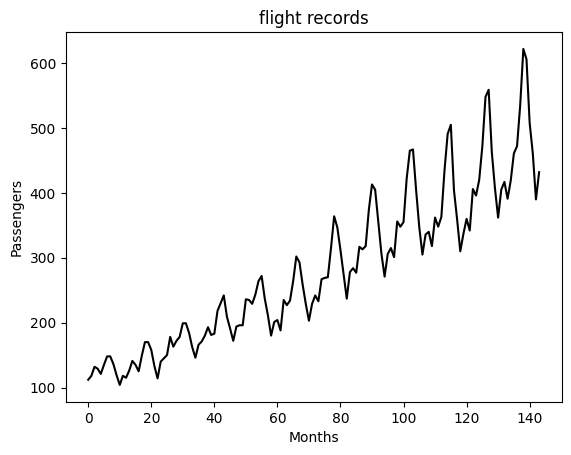

In [ ]:
plt.plot(flights['passengers'], 'k')
plt.title('flight records')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.show()

### 1.3 Normalizing the data and converting to tensor

In a regression problem such as this, it is beneficial to normalize the data. It allows the model to converge faster and avoid having large losses.

In [ ]:
from sklearn.preprocessing import StandardScaler

passengers = flights['passengers'].values.astype(float)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(passengers.reshape(-1,1))

### 1.4 Generating the sequences
Since we have 144 months (i.e., 12 years) of flight data, we use 132 months (i.e., 11 years) for training and the remaining 12 months (i.e., 1 year) for testing.

In [ ]:
# create windowed sequence tuples of (x,y), with moving window of step size = 1
def windowed_sequences(data, window_size=12, test_size=12):
    x = []
    y = []
    for i in range(len(data)-window_size-test_size+1):
        j = i + window_size
        xi = data[i:j]
        yi = data[j]
        x.append(xi)
        y.append(yi)
    return x, y

test_size = 12
seqeunces, targets = windowed_sequences(normalized_data, 12, test_size)

 # Convert the sequences to float type tensors
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

/tmp/ipython-input-4215838445.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)


### 1.5 Constructing the iterables

In [ ]:
# Using pytorch data loading utility to construct iterable over the dataset

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.x = x
        self.y = y

    def __getitem__(self, item):
        return self.x[item],  self.y[item]

    def __len__(self):
        return len(self.x)

train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=24)

### 1.6 Defining the Transformer model

Since we only have 1 input feature and 1 output value (the number of passengers), the input dimension (`input_dim`) and output dimension (`output_dim`) are both set to 1.

The `d_model` parameter defines the embedding size after the input projection layer, which transforms the raw input into a higher-dimensional vector space.

We add **positional encoding** to inject information about the order of the sequence since Transformer models do not have built-in sequential awareness.

The core of the model consists of stacked **Transformer encoder layers**, each containing **multi-head self-attention** and feed-forward networks to capture complex temporal dependencies in the data.

Finally, a fully connected layer maps the output of the last time step from the encoder stack to the predicted passenger count.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    """
    Standard sinusoidal positional encoding to inject time information.
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Create a matrix of [max_len, d_model] representing positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension: [1, max_len, d_model]
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x shape: [batch, seq_len, d_model]
        # Add positional encoding up to the current sequence length
        x = x + self.pe[:, :x.size(1), :]
        return x

class SelfAttention(nn.Module):
    """
    Manually implemented Single Head Attention.
    Replaces torch.nn.MultiheadAttention.
    """
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

        # Projections for Query, Key, and Value
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)

        # Output projection (matches the 'out_proj' in the image)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_len, d_model]
        batch_size, seq_len, d_model = x.size()

        # 1. Linear Projections
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # 2. Scaled Dot-Product Attention
        # Scores = Q @ K^T / sqrt(d_k)
        # Transpose K to [batch, d_model, seq_len] for matrix multiplication
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model)

        # Apply mask (if provided) - usually for causal masking in time series
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        # 3. Softmax to get attention weights
        attn_weights = torch.softmax(scores, dim=-1)

        # 4. Multiply weights by Value
        context = torch.matmul(attn_weights, V)

        # 5. Output projection
        output = self.out_proj(context)

        return output

class TransformerEncoderLayer(nn.Module):
    """
    Manually implemented Encoder Layer matching the image structure:
    - Self Attention -> Dropout -> Add & Norm
    - Feed Forward (Linear -> ReLU -> Dropout -> Linear) -> Dropout -> Add & Norm
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()

        # Attention Block
        self.self_attn = SelfAttention(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-05)

        # Feed Forward Block (matches linear1 -> linear2 in image)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU() # Standard activation
        self.dropout = nn.Dropout(dropout) # Dropout inside FFN
        self.linear2 = nn.Linear(d_ff, d_model)

        self.dropout2 = nn.Dropout(dropout) # Dropout after FFN
        self.norm2 = nn.LayerNorm(d_model, eps=1e-05)

    def forward(self, x, src_mask=None):
        # 1. Self-Attention Sublayer
        # Residual connection: x + Dropout(Attention(x))
        src2 = self.self_attn(x, mask=src_mask)
        src = x + self.dropout1(src2)
        src = self.norm1(src)

        # 2. Feed Forward Sublayer
        # Residual connection: x + Dropout(FFN(x))
        src2 = self.linear2(self.dropout(self.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        return src

# ==========================================
# 2. Main Model Assembly
# ==========================================

class Transformer(nn.Module):
    def __init__(self, input_dim=1, d_model=32, d_ff=2048, num_layers=2, output_dim=1):
        super().__init__()

        # 1. Input Projection (matches 'input_proj' in image)
        self.input_proj = nn.Linear(input_dim, d_model)

        # 2. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # 3. Stack of Encoder Layers (matches 'layers' ModuleList in image)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model=d_model, d_ff=d_ff)
            for _ in range(num_layers)
        ])

        # 4. Final Fully Connected Layer (matches 'fc' in image)
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x, mask=None):
        # Step 1: Project input (batch, seq, 1) -> (batch, seq, 32)
        x = self.input_proj(x)

        # Step 2: Add positional info
        x = self.pos_encoder(x)

        # Step 3: Pass through Transformer layers
        for layer in self.layers:
            x = layer(x, src_mask=mask)

        # Step 4: We typically take the last time step for forecasting
        # (batch, seq, 32) -> (batch, 32) -> (batch, 1)
        # Taking the last element of the sequence:
        last_step = x[:, -1, :]
        output = self.fc(last_step)

        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#2024 modification CPU > GPU
model = Transformer()
model.to(device)#2024 modification CPU > GPU

Transformer(
  (input_proj): Linear(in_features=1, out_features=32, bias=True)
  (pos_encoder): PositionalEncoding()
  (layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): SelfAttention(
        (q_proj): Linear(in_features=32, out_features=32, bias=True)
        (k_proj): Linear(in_features=32, out_features=32, bias=True)
        (v_proj): Linear(in_features=32, out_features=32, bias=True)
        (out_proj): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=32, out_features=2048, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=32, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc): Linear(in_features=32, out_features=1, bi

### 1.7 Printing the network structure

In [ ]:
print(model)

Transformer(
  (input_proj): Linear(in_features=1, out_features=32, bias=True)
  (pos_encoder): PositionalEncoding()
  (layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): SelfAttention(
        (q_proj): Linear(in_features=32, out_features=32, bias=True)
        (k_proj): Linear(in_features=32, out_features=32, bias=True)
        (v_proj): Linear(in_features=32, out_features=32, bias=True)
        (out_proj): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=32, out_features=2048, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=32, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc): Linear(in_features=32, out_features=1, bi

### 1.8 Using Torchinfo to view a summary of the network parameters

In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(24,12,1)) # (batch_size, sequence_length, input_dim)

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [24, 1]                   --
├─Linear: 1-1                            [24, 12, 32]              64
├─PositionalEncoding: 1-2                [24, 12, 32]              --
├─ModuleList: 1-3                        --                        --
│    └─TransformerEncoderLayer: 2-1      [24, 12, 32]              --
│    │    └─SelfAttention: 3-1           [24, 12, 32]              4,224
│    │    └─Dropout: 3-2                 [24, 12, 32]              --
│    │    └─LayerNorm: 3-3               [24, 12, 32]              64
│    │    └─Linear: 3-4                  [24, 12, 2048]            67,584
│    │    └─ReLU: 3-5                    [24, 12, 2048]            --
│    │    └─Dropout: 3-6                 [24, 12, 2048]            --
│    │    └─Linear: 3-7                  [24, 12, 32]              65,568
│    │    └─Dropout: 3-8                 [24, 12, 32]              --
│   

### 1.9 Defining loss function and optimizer

The loss function is defined as Mean Squared Error loss and optimizer is Adam optimizer.



In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### 1.10 Training the network

We loop over our data iterator, and feed the inputs to the
network and optimize the parameters.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(f"Using device: {device}")

model.to('cpu')
t1 = time.time()
loss_list = []
for epoch in range(150):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        seq, labels = data
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_list.append(running_loss/len(train_loader))
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1:3} loss: {running_loss/len(train_loader):.4f}')

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

Using device: cuda
epoch: 100 loss: 0.0244
Finished Training
Training time:36.98408317565918


## Exercise 1.1 Plotting of loss function

In the previous cell, we have saved the loss function at different iterations in the loss_list.

Now, plot the loss function versus the iteration number using matplotlib.

You can find the tutorial of plotting figures using matplotlib here:
https://matplotlib.org/3.3.3/gallery/lines_bars_and_markers/simple_plot.html#sphx-glr-gallery-lines-bars-and-markers-simple-plot-py

### E1.1.1 Example of using matplotlib.pyplot

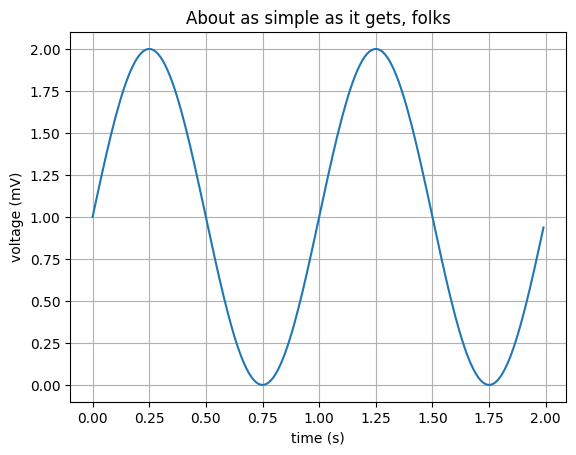

In [ ]:
# An example of a simple plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

plt.show()

### E1.1.2 Plotting the loss function vs interation number (To do)

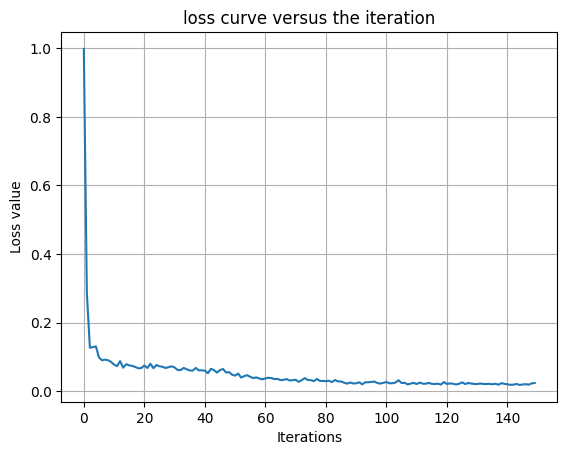

In [ ]:
# Plot the training loss curve
# To do
iterations = np.arange(len(loss_list))

fig, ax = plt.subplots()
ax.plot(iterations, loss_list)
ax.set(xlabel='Iterations', ylabel='Loss value',
       title='loss curve versus the iteration')
ax.grid()

plt.show()

### 1.11 Evaluating network performance on the test data

We have trained the network for several passes over the training dataset.
But we need to check if the network has learned anything at all.

We will check this by predicting the next time-step value that the neural network
outputs, and checking it against the ground truth.



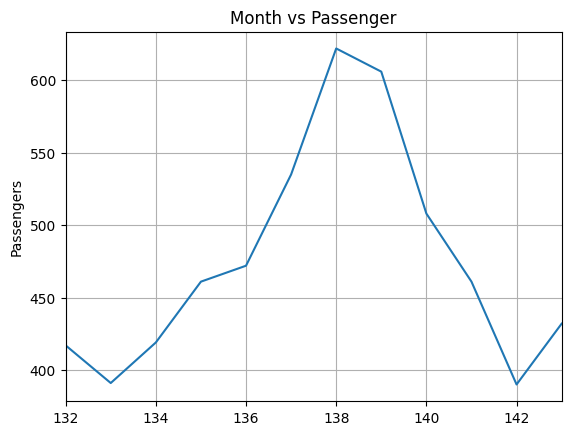

In [ ]:
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis, passengers[-test_size:])
plt.show()

### 1.12 Perform predictions using the trained model



In [ ]:
preds_sl12 = []
with torch.no_grad():
    for i in range(test_size):
        outputs = model(test_seq.unsqueeze(dim=0)) # unsqueeze to add a dimension to accomodate the batch processing
        outputs = outputs.view(1, 1)
        test_seq = torch.cat((test_seq,outputs),dim=0)[-12:]
        preds_sl12.append(outputs)

## Exercise 1.2 Evaluating network performance

In this section, we are going to evaluate the accuracy of the model in predicting future values. Since we are predicting more than 1 value, we will use the Mean Absolute Percentage Error (MAPE) to measure the difference between the predicted value and the ground truth value.

### E1.2.1 Computing MAPE (To do)

Finish the code and calculate the MAPE for 12 future predictions. They can be computed using API from scikit-learn:

MAPE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Ensure preds_sl12 is a tensor and move it to CPU
if isinstance(preds_sl12, torch.Tensor):
    preds_sl12 = preds_sl12.cpu().detach().numpy()  # Convert tensor to NumPy array

# If preds_sl12 is a list of tensors, flatten it
if isinstance(preds_sl12, list):
    preds_sl12 = np.concatenate([x.cpu().detach().numpy().flatten() for x in preds_sl12])

# Reshape to (n_samples, 1) for scaler
denormalized_preds_sl12 = scaler.inverse_transform(preds_sl12.reshape(-1, 1))

# Calculate MAPE
mape = mean_absolute_percentage_error(passengers[-test_size:], denormalized_preds_sl12)

# Print the MAPE as percentage
print(f'MAPE: {mape * 100:.2f}%')

MAPE: 4.71%


### E1.2.2 Plotting the predictions against the data

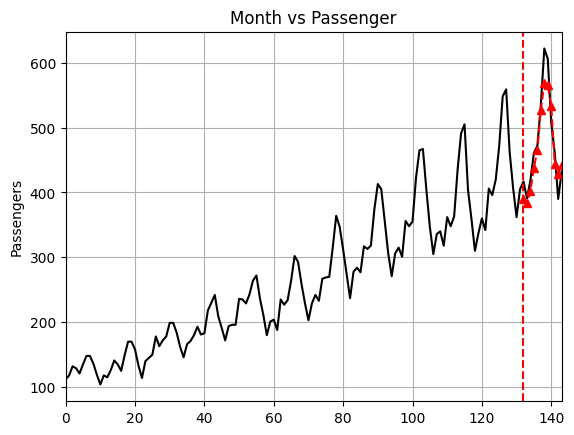

In [ ]:
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(passengers, 'k')
plt.plot(x_axis,denormalized_preds_sl12, 'r^--', label='seq_len_12')
plt.axvline(x=132, color='r', linestyle='--')
plt.show()

### E1.2.3 Zoom in to the predictions

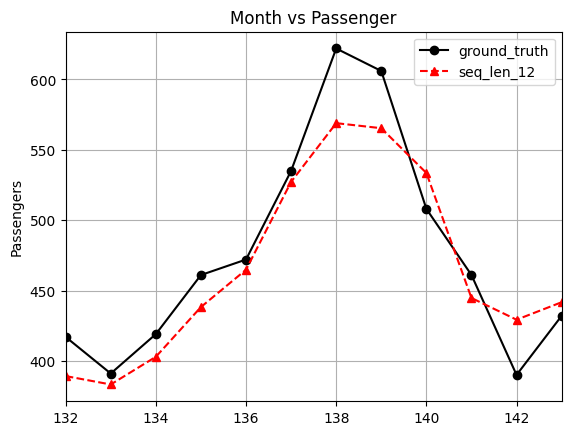

In [ ]:
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis,passengers[-test_size:], 'ko-', label='ground_truth')
plt.plot(x_axis,denormalized_preds_sl12, 'r^--', label='seq_len_12')
plt.legend()
plt.show()

## E1.3 Study of different window/sequence lengths

In this exercise, you will learn to train the network with the input of a different window/sequence length.

In the previous section, we used a sequence length of 12 for the time series input. You will use a sequence length of 24 in this exercise and compare the evaluation results for these two window/sequence lengths.

### E1.3.1 Prepare the new training iterables (To do)

In [ ]:
# To do
seqeunces, targets = windowed_sequences(normalized_data, 24, test_size)
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=24)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

### E1.3.2 Re-initializing the network and optimizer

In [ ]:
model = Transformer()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### E1.3.3 Training the network with the new input sequences

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#2024 modification CPU > GPU
model.to(device)#2024 modification CPU > GPU
t1 = time.time()
loss_list = []
for epoch in range(150):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        seq, labels = data
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/len(train_loader))
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1:3} loss: {running_loss/len(train_loader):.4f}')

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

epoch: 100 loss: 0.0356
Finished Training
Training time:5.115090608596802


### E1.3.4 Perform predictions

Perform predictions using the model trained on inputs sequence length = 24.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#2024 modification CPU > GPU
model.to(device)#2024 modification CPU > GPU
preds_sl24 = []
with torch.no_grad():
    for i in range(test_size):
        test_seq = test_seq.to(device)
        outputs = model(test_seq.unsqueeze(dim=0)) # unsqueeze to add a dimension to accomodate the batch processing
        test_seq = torch.cat((test_seq,outputs),dim=0)[-24:]
        preds_sl24.append(outputs)

### E1.3.5 Evaluate performance

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Check if preds_sl24 is a list, and convert to a NumPy array
if isinstance(preds_sl24, list):
    # If it's a list of tensors, we need to convert each tensor to NumPy
    preds_sl24 = np.concatenate([x.cpu().detach().numpy().flatten() if isinstance(x, torch.Tensor) else np.array(x).flatten() for x in preds_sl24])#2024 modification CPU > GPU

# Now preds_sl24 is a 1D NumPy array, reshape it to (n_samples, 1) for the scaler
denormalized_preds_sl24 = scaler.inverse_transform(preds_sl24.reshape(-1, 1))#2024 modification CPU > GPU

# Calculate MAPE
mape = mean_absolute_percentage_error(passengers[-test_size:], denormalized_preds_sl24)

# Print the MAPE as percentage
print(f'MAPE: {mape * 100:.2f}%')

MAPE: 12.49%


### E1.3.6 Plotting the results for both sequence lengths (To do)

Re-plot the plot in E1.2.3 by adding the input-sequence-length-24 prediction.

Specifically, plot the ground truth (in black and label it as 'ground truth'), the sequence-length-12 prediction (in red dotted line with ^ marker and label it as 'seq_len_12'), and the sequence-length-24 prediction (in green dotted line with x marker and label it as 'seq_len_24').

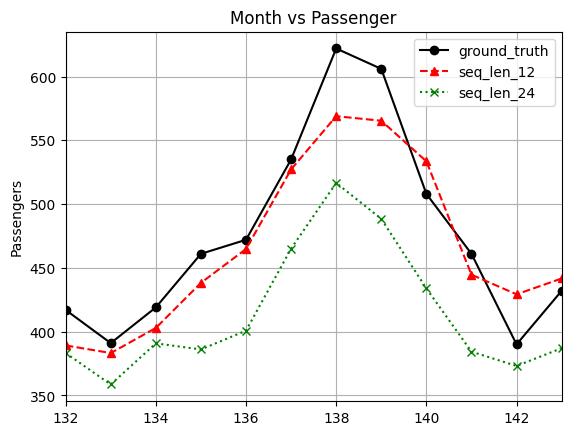

In [ ]:
# To do
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis,passengers[-test_size:], 'ko-', label='ground_truth')
plt.plot(x_axis,denormalized_preds_sl12, 'r^--', label='seq_len_12')
plt.plot(x_axis,denormalized_preds_sl24, 'gx:', label='seq_len_24')
plt.legend()
plt.show()

## Exercise 1.4 Study of different hidden dimensions

In this exercise, you will learn to train the network using a different hidden layer dimension.

In the previous section, we used a hidden dimension of 200. You will use a hidden dimension of 400 in this exercise and compare the results for these 2 hidden dimensions. We will keep the window/sequence length of 12.

### E1.4.1 Re-initializing the network with different hidden dimensions (To do)

### E1.4.2 View a summary of the network parameters

In [ ]:
# To do
model = Transformer(d_model=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # lower learning may be better for more complex model

In [ ]:
from torchinfo import summary
summary(model, input_size=(24,12,1))

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [24, 1]                   --
├─Linear: 1-1                            [24, 12, 64]              128
├─PositionalEncoding: 1-2                [24, 12, 64]              --
├─ModuleList: 1-3                        --                        --
│    └─TransformerEncoderLayer: 2-1      [24, 12, 64]              --
│    │    └─SelfAttention: 3-1           [24, 12, 64]              16,640
│    │    └─Dropout: 3-2                 [24, 12, 64]              --
│    │    └─LayerNorm: 3-3               [24, 12, 64]              128
│    │    └─Linear: 3-4                  [24, 12, 2048]            133,120
│    │    └─ReLU: 3-5                    [24, 12, 2048]            --
│    │    └─Dropout: 3-6                 [24, 12, 2048]            --
│    │    └─Linear: 3-7                  [24, 12, 64]              131,136
│    │    └─Dropout: 3-8                 [24, 12, 64]              --

### E1.4.3 Reinitialize the training iterables

In [ ]:
window_size = 12
test_size = 12
seqeunces, targets = windowed_sequences(normalized_data, window_size, test_size)
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=24)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

### E1.4.4 Training the network with new hidden dimension

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#2024 modification CPU > GPU
model.to(device)#2024 modification CPU > GPU
t1 = time.time()
loss_list = []
for epoch in range(150):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        seq, labels = data
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/len(train_loader))
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1:3} loss: {running_loss/len(train_loader):.4f}')

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

epoch: 100 loss: 0.0180
Finished Training
Training time:4.2423999309539795


### E1.4.5 Perform predictions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#2024 modification CPU > GPU
model.to(device)#2024 modification CPU > GPU
preds_hd400 = []
with torch.no_grad():
    for i in range(test_size):
        test_seq = test_seq.to(device)
        outputs = model(test_seq.unsqueeze(dim=0)) # unsqueeze to add a dimension to accomodate the batch processing
        test_seq = torch.cat((test_seq,outputs),dim=0)[-12:]
        preds_hd400.append(outputs)

### E1.4.6 Evaluate performance

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# If preds_hd400 is a list, convert it to a NumPy array
if isinstance(preds_hd400, list):
    # Convert the list into a 1D NumPy array
    preds_hd400 = np.concatenate([x.cpu().detach().numpy().flatten() if isinstance(x, torch.Tensor) else np.array(x).flatten() for x in preds_hd400])#2024 modification CPU > GPU

# If preds_hd400 is a tensor (after conversion from the list), move it to CPU
elif isinstance(preds_hd400, torch.Tensor):
    preds_hd400 = preds_hd400.cpu().detach().numpy() #2024 modification CPU > GPU

# Reshape the array to a column vector (if needed) before inverse transform
denormalized_preds_hd400 = scaler.inverse_transform(preds_hd400.reshape(-1, 1))#2024 modification CPU > GPU

# Calculate MAPE
mape = mean_absolute_percentage_error(passengers[-test_size:], denormalized_preds_hd400)

# Print the MAPE as percentage
print(f'MAPE: {mape * 100:.2f}%')


MAPE: 3.59%


### E1.4.7 Plotting the results in the same plot (To do)

Re-plot the plot in E1.2.3 by adding the hidden-dimension-400 prediction.

Specifically, plot the the ground truth (in black and label it as 'ground truth'), the hidden-dimension-200 prediction (in red dotted line with ^ marker and label it as 'hid_dim_200'), and the hidden-dimension-400 prediction (in green dotted line with x marker and label it as 'hid_dim_400').


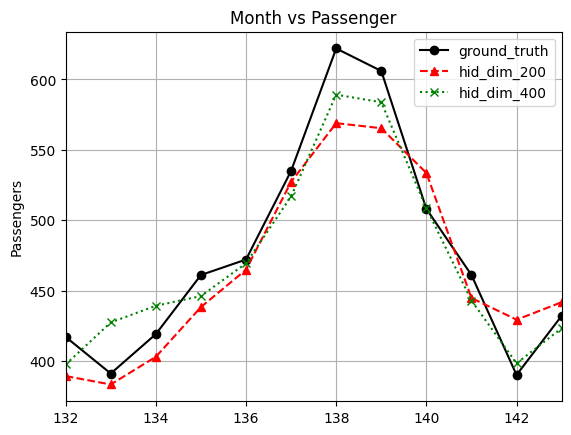

In [ ]:
# To do
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis,passengers[-test_size:], 'ko-', label='ground_truth')
plt.plot(x_axis,denormalized_preds_sl12, 'r^--', label='hid_dim_200')
plt.plot(x_axis,denormalized_preds_hd400, 'gx:', label='hid_dim_400')
plt.legend()
plt.show()